## Compare GegenbauerKAN's ability in function interpolation with MLP

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from GegenbauerKANLayer import GegenbauerKANLayer

In [6]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    return y

In [7]:
alpha_ = 3
# Define MLP and GegenbauerKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)


class GegenbauerKAN(nn.Module):
    def __init__(self):
        super(GegenbauerKAN, self).__init__()
        self.gegenbauerkan1 = GegenbauerKANLayer(1, 8, 8, alpha_)
        self.gegenbauerkan2 = GegenbauerKANLayer(8, 1, 8, alpha_)

    def forward(self, x):
        x = self.gegenbauerkan1(x)
        x = self.gegenbauerkan2(x)
        return x

Epoch 1/3000, GegenbauerKAN Loss: 4773.4985, MLP Loss: 0.5946
Epoch 101/3000, GegenbauerKAN Loss: 0.8148, MLP Loss: 0.1975
Epoch 201/3000, GegenbauerKAN Loss: 0.3373, MLP Loss: 0.1865
Epoch 301/3000, GegenbauerKAN Loss: 0.2528, MLP Loss: 0.1827
Epoch 401/3000, GegenbauerKAN Loss: 0.2192, MLP Loss: 0.1797
Epoch 501/3000, GegenbauerKAN Loss: 0.1974, MLP Loss: 0.1774
Epoch 601/3000, GegenbauerKAN Loss: 0.1802, MLP Loss: 0.1735
Epoch 701/3000, GegenbauerKAN Loss: 0.1655, MLP Loss: 0.1689
Epoch 801/3000, GegenbauerKAN Loss: 0.1530, MLP Loss: 0.1692
Epoch 901/3000, GegenbauerKAN Loss: 0.1421, MLP Loss: 0.1652
Epoch 1001/3000, GegenbauerKAN Loss: 0.1326, MLP Loss: 0.1622
Epoch 1101/3000, GegenbauerKAN Loss: 0.1242, MLP Loss: 0.1598
Epoch 1201/3000, GegenbauerKAN Loss: 0.1167, MLP Loss: 0.1572
Epoch 1301/3000, GegenbauerKAN Loss: 0.1100, MLP Loss: 0.1535
Epoch 1401/3000, GegenbauerKAN Loss: 144.3399, MLP Loss: 0.1481
Epoch 1501/3000, GegenbauerKAN Loss: 0.1665, MLP Loss: 0.1431
Epoch 1601/3000

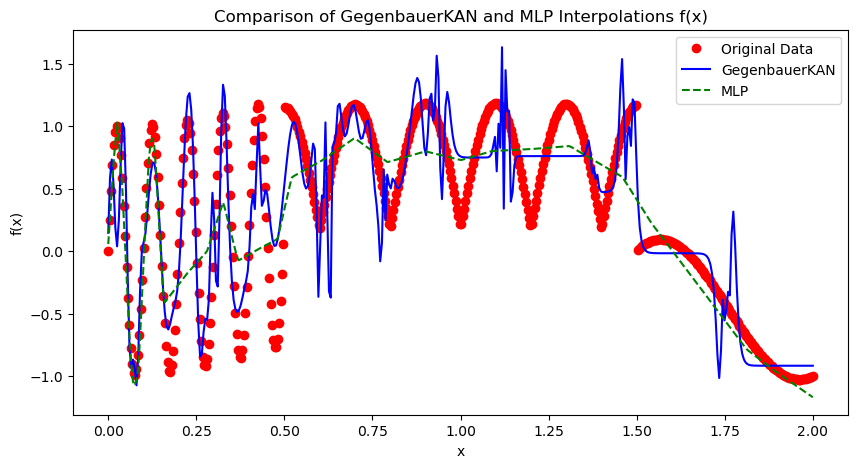

In [8]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
gegenbauer_model = GegenbauerKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_gegenbauer = torch.optim.Adam(gegenbauer_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the models
epochs = 3000
for epoch in range(epochs):
    optimizer_gegenbauer.zero_grad()
    outputs_gegenbauer = gegenbauer_model(x_train)
    loss_gegenbauer = criterion(outputs_gegenbauer, y_train)
    loss_gegenbauer.backward()
    optimizer_gegenbauer.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, GegenbauerKAN Loss: {loss_gegenbauer.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_gegenbauer = gegenbauer_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_gegenbauer.numpy(), 'b-', label='GegenbauerKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of GegenbauerKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()